In [119]:
import numpy as np
import cv2
import xmltodict
from tqdm import tqdm
import tensorflow as tf
from glob import glob
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

In [120]:
train_image_path="/YOLO_v1/data/train/images"
train_xml_path="/YOLO_v1/data/train/xmls"
test_image_path="/YOLO_v1/data/test/images"
test_xml_path="/YOLO_v1/data/test/xmls"

train_image_path_list = sorted([x for x in glob(train_image_path + '/**')])
train_xml_path_list = sorted([x for x in glob(train_xml_path + '/**')])
test_image_path_list = sorted([x for x in glob(test_image_path + '/**')])
test_xml_path_list = sorted([x for x in glob(test_xml_path + '/**')])

initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.01)
regularizer = tf.keras.regularizers.l2(0.0005)

In [121]:
def get_classes_data(xml_file_path_list):
    classes = []
    
    for xml_file_path in xml_file_path_list:
        f=open(xml_file_path)
        xml_file=xmltodict.parse(f.read())
        try:
            for obj in xml_file['annotation']['object']:
                classes.append(obj['name'])
        except TypeError as e:
            classes.append(xml_file['annotation']['object']['name'])
        except KeyError:
            print(xml_file_path)
        f.close()

    classes=list(set(classes))
    return sorted(classes)

In [122]:
def get_label(xml_file_path, classes, random_param=1.0):
    N = len(classes)
    f = open(xml_file_path)
    xml_file = xmltodict.parse(f.read())
    
    height = float(xml_file['annotation']['size']['height'])
    width = float(xml_file['annotation']['size']['width'])

    # output shape = 7x7x30 -> 7x7x11  (5 + num of classes)
    label = np.zeros((7,7,5+N), dtype = float)

    # make object shape (-1,) regardless of single, multi ojbect in image    
    for obj in np.reshape([xml_file['annotation']['object']], (-1,)):
        class_index = classes.index(obj['name'])

        y_min = float(obj['bndbox']['ymin'])
        y_max = float(obj['bndbox']['ymax'])
        x_min = float(obj['bndbox']['xmin'])
        x_max = float(obj['bndbox']['xmax'])
            
        # make img to 448 x 448
        y = 448.0 / height * (y_min + y_max) / 2
        x = 448.0 / width * (x_min + x_max) / 2
        h = (y_max - y_min) / height # 0~1
        w = (x_max - x_min) / width

        # find cell which x, y are existed
        y_cell = int(y/64)
        x_cell = int(x/64)
        y_incell = y/64 - y_cell # 0~1
        x_incell = x/64 - x_cell

        label[y_cell][x_cell][0] = y_incell
        label[y_cell][x_cell][1] = x_incell
        label[y_cell][x_cell][2] = h
        label[y_cell][x_cell][3] = w
        label[y_cell][x_cell][4] = 1.0
        label[y_cell][x_cell][5 + class_index] = 1.0
    return label

In [123]:
def randomly_scaling(img, check=True):
    if check:
        return img
    else:
        scale_param=np.random.uniform(low=0.6, high=1.0)
        img = cv2.resize(img, (448, 448))
        return cv2.resize(img, (int(448 * scale_param), int(448 * scale_param)))

In [124]:
def make_dataset(image_path_list, xml_path_list, classes):
    N=len(classes)
    image_dataset = []
    label_dataset = []
    
    for i in tqdm(range(0, len(image_path_list)), desc = "make dataset"):
        image = cv2.imread(image_path_list[i])
        scale_param = np.random.random()
        image = randomly_scaling(image, scale_param<0.8)
        image = cv2.resize(image, (448, 448)) / 255.0
        label = get_label(xml_path_list[i], classes)

        image_dataset.append(image)
        label_dataset.append(label)

    image_dataset = np.array(image_dataset, dtype="object")
    label_dataset = np.array(label_dataset, dtype="object")

    image_dataset = np.reshape(image_dataset, (-1, 448, 448, 3)).astype(np.float32)
    label_dataset = np.reshape(label_dataset, (-1, 7, 7, 5+N))
    return tf.convert_to_tensor(image_dataset, dtype=tf.float32), tf.convert_to_tensor(label_dataset, dtype=tf.float32)

In [125]:
def get_backbone(model, activation):
    if model=="VGG16":
        backbone=tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(448, 448, 3))
    YOLO = tf.keras.models.Sequential(name="YOLO")
    for layer in backbone.layers:
        YOLO.add(layer)
        layer.trainable=False
    for layer in YOLO.layers:
        if hasattr(layer, 'activation')==True:
            layer.activation=activation
    return YOLO

In [126]:
def get_YOLO(YOLO, initializer, activation, regularizer, N):
        YOLO.add(tf.keras.layers.Conv2D(1024, (3, 3), activation=activation, kernel_initializer=initializer, 
                kernel_regularizer=regularizer, padding="SAME", name="detection_conv1", dtype="float32"))
        YOLO.add(tf.keras.layers.Conv2D(1024, (3, 3), activation=activation, kernel_initializer=initializer,
                kernel_regularizer=regularizer, padding="SAME", name="detection_conv2", dtype="float32"))
        YOLO.add(tf.keras.layers.MaxPool2D((2, 2)))
        YOLO.add(tf.keras.layers.Conv2D(1024, (3, 3), activation=activation, kernel_initializer=initializer,
                kernel_regularizer=regularizer, padding="SAME", name="detection_conv3", dtype="float32"))
        YOLO.add(tf.keras.layers.Conv2D(1024, (3, 3), activation=activation, kernel_initializer=initializer,
                kernel_regularizer=regularizer, padding="SAME", name="detection_conv4", dtype="float32"))
        YOLO.add(tf.keras.layers.Flatten())
        YOLO.add(tf.keras.layers.Dense(4096, activation=activation, kernel_initializer=initializer, 
                kernel_regularizer=regularizer, name="detection_linear1", dtype="float32"))
        YOLO.add(tf.keras.layers.Dropout(0.5))
        YOLO.add(tf.keras.layers.Dense(7*7*(10+N), activation='sigmoid', kernel_initializer=initializer, 
                kernel_regularizer=regularizer, name="detection_linear2", dtype="float32"))
        YOLO.add(tf.keras.layers.Reshape((7,7,10+N), name = "output", dtype="float32"))
        return YOLO

In [127]:
def box_to_point(bbox):
    cy, cx, h, w = bbox[:,:,0], bbox[:,:,1], bbox[:,:,2], bbox[:,:,3]
    y1, x1 = cy - 0.5*h, cx - 0.5*w
    y2, x2 = cy + 0.5*h, cx + 0.5*w
    return [y1, x1, y2, x2]

In [128]:
def get_intersection(bbox, gtbox):
    y1, x1 = tf.maximum(bbox[0], gtbox[0]), tf.maximum(bbox[1], gtbox[1])
    y2, x2 = tf.minimum(bbox[2], gtbox[2]), tf.minimum(bbox[3], gtbox[3])
    return tf.maximum(y2-y1, 0.0) * tf.maximum(x2-x1, 0.0)

In [129]:
def yolo_multitask_loss(y_true, y_pred):
    lambda_coord=5
    lambda_noobj=0.5
    N=len(y_true[0][0][0])-5

    # localization loss
    y_true_unit = tf.reshape(y_true, (-1, 49, 5+N))
    y_pred_unit = tf.reshape(y_pred, (-1, 49, 10+N))
        
    bbox1 = y_pred_unit[:,:,:4]
    bbox1_confidence = y_pred_unit[:,:,4]
    bbox2 = y_pred_unit[:,:,5:9]
    bbox2_confidence = y_pred_unit[:,:,9]
    bbox_class = y_pred_unit[:,:,10:]

    gtbox = y_true_unit[:,:,:4]
    gtbox_confidence = y_true_unit[:,:,4]
    gtbox_class = y_true_unit[:,:,5:]

    bbox1_2p = box_to_point(bbox1)
    bbox2_2p = box_to_point(bbox2)
    gtbox_2p = box_to_point(gtbox)

    intersection1 = get_intersection(bbox1_2p, gtbox_2p)
    intersection2 = get_intersection(bbox2_2p, gtbox_2p)

    gtbox_area = gtbox[:,:,2] * gtbox[:,:,3] 
    union1 = bbox1[:,:,2] * bbox1[:,:,3] + gtbox_area + 1e-6
    union2 = bbox2[:,:,2] * bbox2[:,:,3] + gtbox_area + 1e-6

    iou1 = intersection1 / union1
    iou2 = intersection2 / union2

    responsible_iou = tf.where(tf.greater(iou1,iou2), iou1, iou2)
    iou1 = tf.expand_dims(iou1, -1)
    iou2 = tf.expand_dims(iou2, -1)
    responsible_box = tf.where(tf.greater(iou1,iou2), bbox1, bbox2)
    iou1 = tf.squeeze(iou1,-1)
    iou2 = tf.squeeze(iou2,-1)
    responsible_confidence = tf.where(tf.greater(iou1,iou2), bbox1_confidence, bbox2_confidence)
    non_responsible_confidence = tf.where(tf.greater(iou1,iou2), bbox2_confidence, bbox1_confidence)

    err_y = (gtbox[:,:,0] - responsible_box[:,:,0])**2
    err_x = (gtbox[:,:,1] - responsible_box[:,:,1])**2
    err_h = (tf.sqrt(tf.maximum(gtbox[:,:,2], 1e-9)) - tf.sqrt(tf.maximum(responsible_box[:,:,2], 1e-9)))**2
    err_w = (tf.sqrt(tf.maximum(gtbox[:,:,3], 1e-9)) - tf.sqrt(tf.maximum(responsible_box[:,:,3], 1e-9)))**2

    localization_loss = gtbox_confidence * (err_x + err_x + err_h + err_w)
    localization_loss = tf.where(tf.math.is_nan(localization_loss), tf.zeros_like(localization_loss), localization_loss)
    localization_loss = tf.reduce_sum(localization_loss, -1)
    localization_loss *= lambda_coord

    # confidence loss
    confidence_loss_obj = tf.reduce_sum(gtbox_confidence * (tf.ones_like(gtbox_confidence) - responsible_confidence)**2, -1)
    confidence_loss_noobj = tf.reduce_sum((tf.ones_like(gtbox_confidence) - gtbox_confidence) * (non_responsible_confidence)**2, -1)
    confidence_loss_noobj *= lambda_noobj
    confidence_loss = confidence_loss_obj + confidence_loss_noobj

    # classification loss
    classification_loss = tf.reduce_sum(gtbox_confidence * tf.reduce_sum((gtbox_class - bbox_class)**2,-1), -1)
    # total loss
    loss = localization_loss + confidence_loss + classification_loss
    return loss

In [130]:
def lr_schedule(epoch, lr):
        if 0 <= epoch <75 :
            lr = 0.001 + 0.009 * epoch/75.0
        elif 75 <= epoch < 105 :
            lr = 0.001
        elif 105 <= epoch <135:
            lr = 0.0001
        else:
            lr = 0.00001
        return lr

In [131]:
def train(YOLO, train_dataset, validation_dataset, batch_size=16, epochs=135, lr_func=lr_schedule, save_filename='YOLO_v1.h5'):
    callbacks=[LearningRateScheduler(lr_func)]
    if save_filename:
        callbacks.append(ModelCheckpoint(save_filename,
                                         verbose=1,
                                         save_best_only=True))
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum = 0.9)
    YOLO.compile(loss = yolo_multitask_loss, optimizer=optimizer)
    YOLO.fit(train_dataset[0], train_dataset[1], 
             batch_size=batch_size, 
             validation_data=validation_dataset,
             epochs=epochs,
             verbose=1,
             callbacks=callbacks)
            

In [132]:
def evaluate(YOLO, validation_dataset, batch_size=16):
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum = 0.9)
    YOLO.compile(loss = yolo_multitask_loss, optimizer=optimizer)
    result = YOLO.evaluate(validation_dataset[0],validation_dataset[1], batch_size=batch_size)          
    print(result)

In [133]:
def process_bbox(y, x, bbox, image_size, classes_score, classes):
    bbox_y = ((64.0 * y) + (bbox[0] * 64.0)) * (image_size[0]/448.0)
    bbox_x = ((64.0 * x) + (bbox[1] * 64.0)) * (image_size[1]/448.0)
    bbox_h = bbox[2] * image_size[0]
    bbox_w = bbox[3] * image_size[1]
    
    min_y = max(0, int(bbox_y - bbox_h/2))
    min_x = max(0, int(bbox_x - bbox_w/2))
    max_y = min(image_size[0], int(bbox_y + bbox_h/2))
    max_x = min(image_size[1], int(bbox_x + bbox_w/2))

    idx_class_hightes_score = np.argmax(classes_score)
    class_highest_score = classes_score[idx_class_hightes_score]
    class_highest_score_name = classes[idx_class_hightes_score]

    output_bbox = [min_y, min_x, max_y, max_x, class_highest_score, idx_class_hightes_score]
    return output_bbox

In [134]:
def nms(img_bbox_list, threshold=0.8):
    img_nms_bbox_list=[]
    for bbox_list in img_bbox_list:
        nms_bbox_list=[]
        bbox_list_tf=tf.convert_to_tensor(bbox_list)
        idx=tf.image.non_max_suppression(bbox_list_tf[:,:4], bbox_list_tf[:,4],
                                        max_output_size = 5,
                                        iou_threshold=0.5,
                                        score_threshold=threshold)
        for i in idx:
            nms_bbox_list.append(bbox_list[i])
        img_nms_bbox_list.append(nms_bbox_list)
    return img_nms_bbox_list

In [178]:
def get_YOLO_output(YOLO, image_path_list, label_path_list, classes):
    def get_data(image_path_list, label_path_list):
        if type(image_path_list)==str:
            image_path_list=[image_path_list]
            label_path_list=[label_path_list]
        images, images_resized, labels, images_size = [], [], [], []
        for image_path, label_path in zip(image_path_list, label_path_list):
            image = cv2.imread(image_path) / 255.0
            image_resized = cv2.resize(image, (448,448))
            image = np.asarray(image, dtype=np.float32)
            label = get_label(label_path, classes)
            images.append(image)
            images_resized.append(image_resized)
            labels.append(label)
            images_size.append(image.shape[:2])
        return images, np.array(images_resized), np.array(labels), images_size

    def extract_box(labels):
        img_bbox=[]
        B=2 if labels.shape[-1] == 16 else 1

        for i in range(n):
            bbox_list=[]
            for y in range(7):
                for x in range(7):
                    for b in range(1, B+1):
                        bbox_class_score = labels[i][y][x][5*B:] * labels[i][y][x][5*b-1]
                        bbox = labels[i][y][x][5*(b-1):5*b-1]
                        p_bbox = process_bbox(y, x, bbox, images_size[i], bbox_class_score, classes)
                        bbox_list.append(p_bbox)
            img_bbox.append(bbox_list)
        return img_bbox

    def show(img_nms_list, column=1):
        for i, [image, nms_bbox_list], in enumerate(zip(images, img_nms_list)):
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                for nms_bbox in nms_bbox_list:
                    min_box = (nms_bbox[1], nms_bbox[0])
                    max_box = (nms_bbox[3], nms_bbox[2])
                    cv2.rectangle(image, min_box, max_box, (0,1,0), 3)
                    show_str = classes[nms_bbox[5]]

                    text_min_box = (nms_bbox[1] + 2, nms_bbox[0] -10)
                    text_max_box = (nms_bbox[3], nms_bbox[0])

                    cv2.rectangle(image, text_min_box, text_max_box, (0,0,1), -1)

                    cv2.putText(image, show_str, (min_box[0] + 2, min_box[1] -1), cv2.FONT_HERSHEY_PLAIN, 0.7, (0,0,0),1)
                plt.subplot(n,2,i*2+column)
                plt.imshow(image)
    
    images, images_resized, labels, images_size = get_data(image_path_list, label_path_list)
    n = images_resized.shape[0]
    output = YOLO(images_resized).numpy()
    
    img_bbox_list = extract_box(output)
    img_nms_bbox_list = nms(img_bbox_list)
    img_gtbox_list = extract_box(labels)
    img_nms_gtbox_list = nms(img_gtbox_list, 0.99)

    plt.figure(figsize=(15,30))
    show(img_nms_bbox_list)
    show(img_nms_gtbox_list, 2)
    plt.show()

In [136]:
classes = get_classes_data(train_xml_path_list)
N=len(classes)
classes

['Choi Woo-shik',
 'Kim Da-mi',
 'Kim Seong-cheol',
 'Kim Tae-ri',
 'Nam Joo-hyuk',
 'Yoo Jae-suk']

In [137]:
train_dataset = make_dataset(train_image_path_list, train_xml_path_list, classes)
test_dataset = make_dataset(test_image_path_list, test_xml_path_list, classes)

make dataset: 100%|██████████| 51/51 [00:00<00:00, 100.00it/s]


In [138]:
backbone = get_backbone("VGG16", leaky_relu)
YOLO=get_YOLO(backbone, initializer, leaky_relu, regularizer, N)
# YOLO.summary()

In [139]:
train(YOLO, train_dataset, test_dataset, batch_size=16, epochs=200)

Epoch 1/200
31/31 [==============================] - ETA: 0s - loss: 17.4176
Epoch 1: val_loss improved from inf to 16.21310, saving model to YOLO_v1.h5
31/31 [==============================] - 14s 294ms/step - loss: 17.4176 - val_loss: 16.2131 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - ETA: 0s - loss: 15.3711
Epoch 2: val_loss improved from 16.21310 to 15.33138, saving model to YOLO_v1.h5
31/31 [==============================] - 7s 230ms/step - loss: 15.3711 - val_loss: 15.3314 - lr: 0.0011
Epoch 3/200
31/31 [==============================] - ETA: 0s - loss: 14.7278
Epoch 3: val_loss did not improve from 15.33138
31/31 [==============================] - 5s 145ms/step - loss: 14.7278 - val_loss: 15.4557 - lr: 0.0012
Epoch 4/200
31/31 [==============================] - ETA: 0s - loss: 14.5327
Epoch 4: val_loss improved from 15.33138 to 15.17323, saving model to YOLO_v1.h5
31/31 [==============================] - 7s 231ms/step - loss: 14.5327 - val_loss: 15.1732 - 

In [140]:
YOLO_load = tf.keras.models.load_model('YOLO_v1.h5', custom_objects={'yolo_multitask_loss':yolo_multitask_loss})
YOLO_load.summary()

Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 448, 448, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 448, 448, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 224, 224, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 224, 224, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 224, 224, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 112, 112, 128)     0         
                                                                 
 block3_conv1 (Conv2D)       (None, 112, 112, 256)     295168 

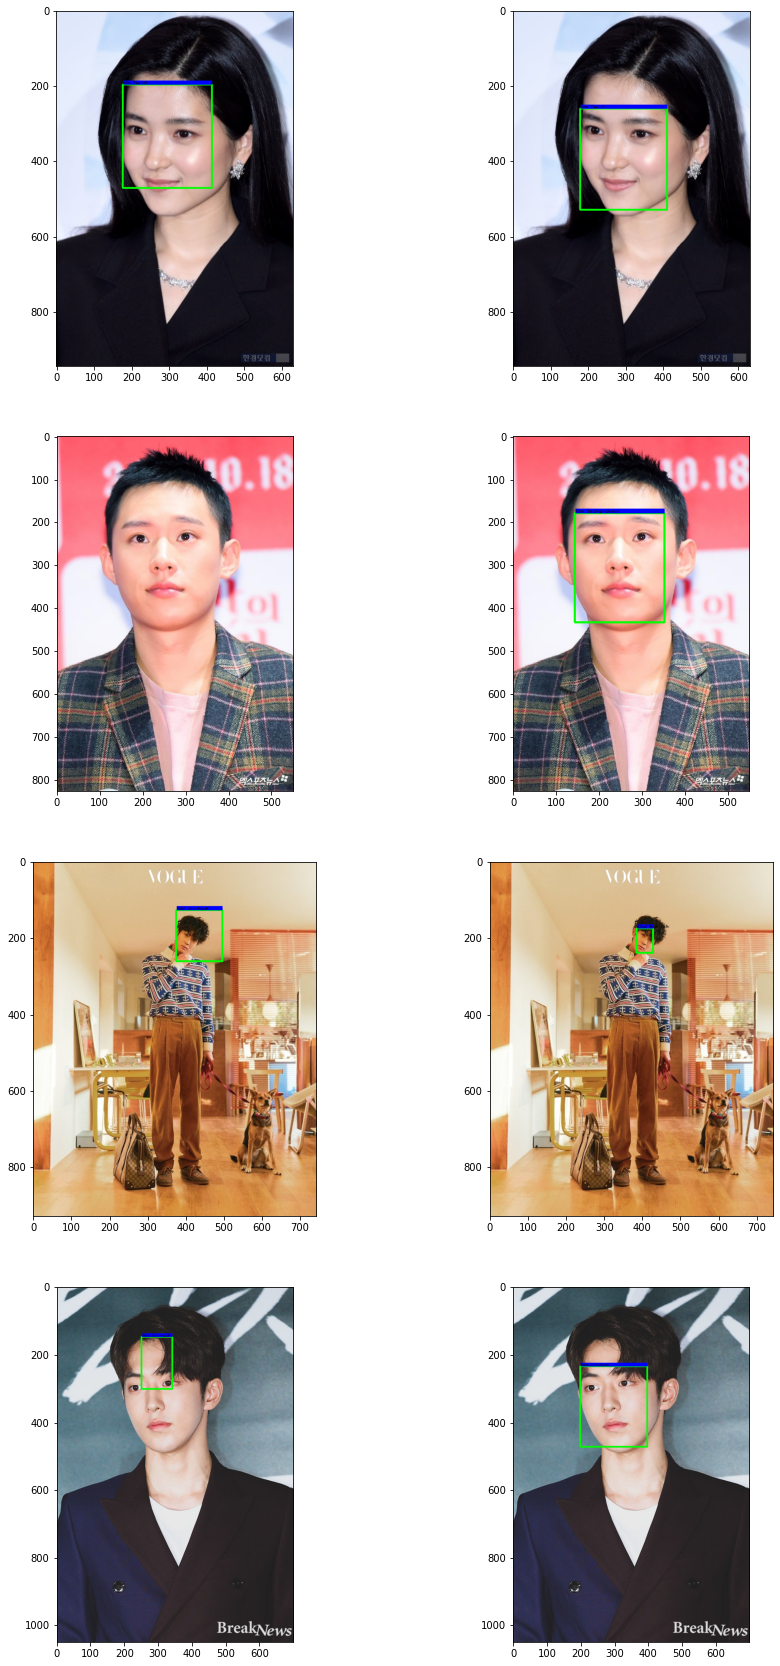

In [177]:
get_YOLO_output(YOLO_load, test_image_path_list[:4], test_xml_path_list[:4], classes)

(4,)


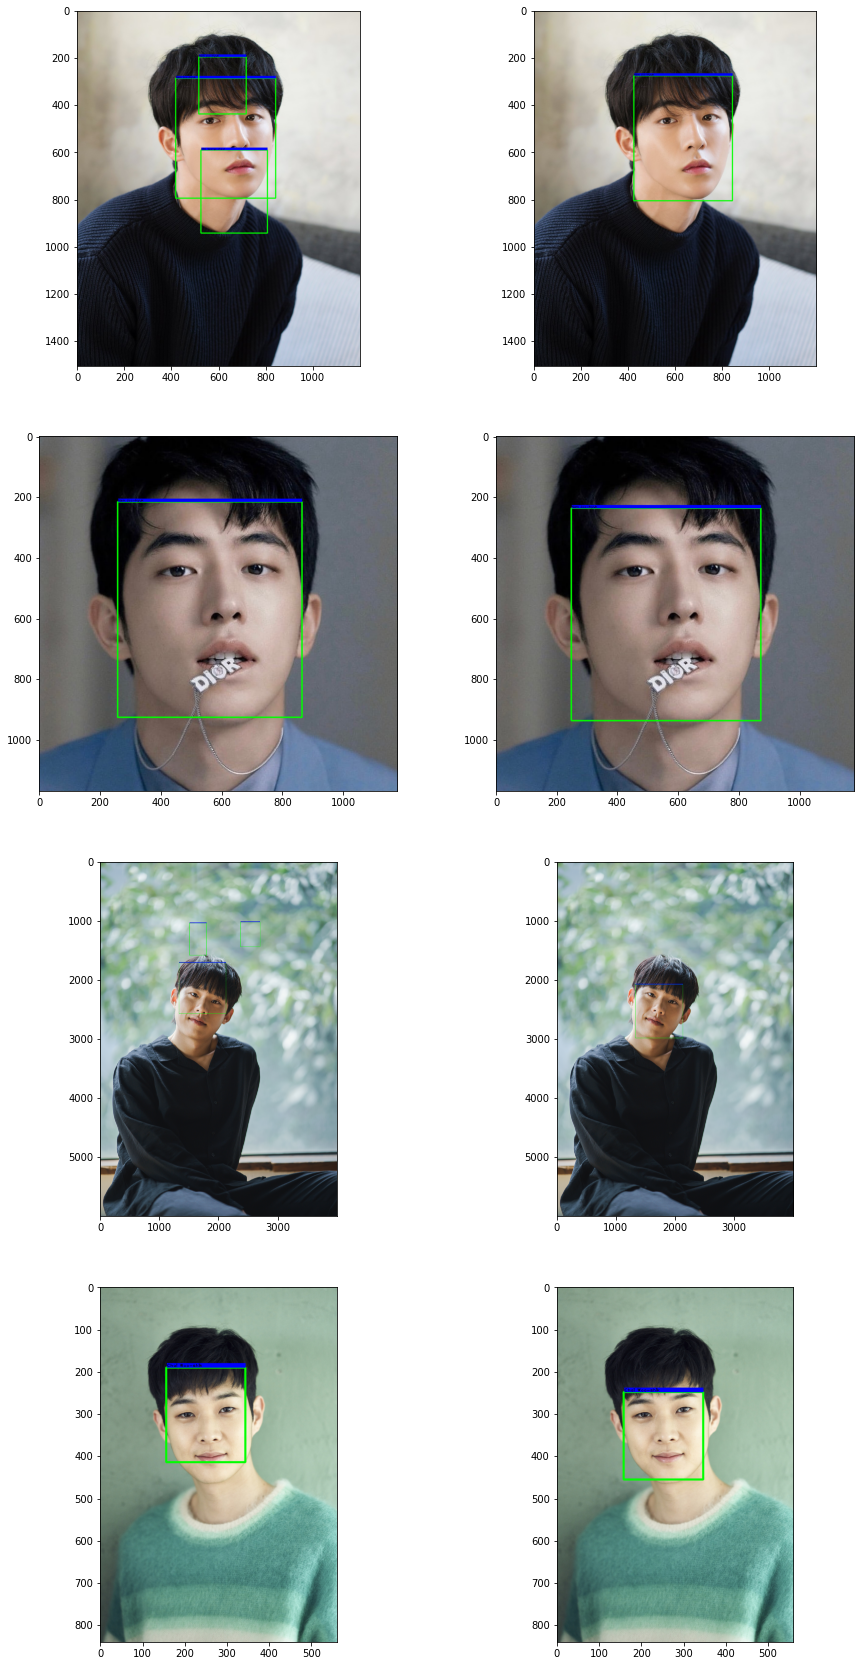

In [143]:
get_YOLO_output(YOLO_load, train_image_path_list[:4], train_xml_path_list[:4], classes)

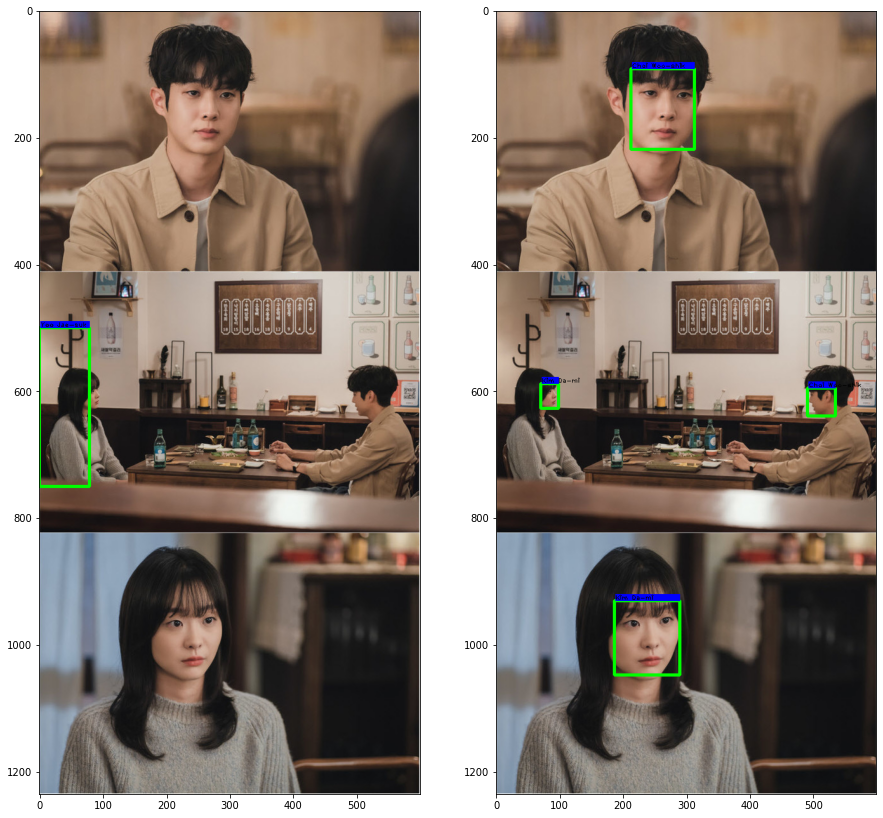

In [175]:
get_YOLO_output(YOLO_load, test_image_path_list[30], test_xml_path_list[30], classes)

In [176]:
evaluate(YOLO_load, test_dataset)

4/4 [==============================] - 1s 77ms/step - loss: 11.0743
11.074307441711426
